In [1]:
import pandas as pd
from tqdm import tqdm
# Train Random Forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

/opt/homebrew/anaconda3/envs/adaexam/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def compute_clustering_metrics(df1, df2):
    """
    Compute precision, recall, and F1 score for clustering assignments
    
    Args:
        df1: DataFrame with columns [transaction_reference_id, external_id]
        df2: DataFrame with columns [transaction_reference_id, external_id]
    
    Returns:
        dict: Contains precision, recall, and F1 score
    """
    # Create dictionaries mapping transaction_id to cluster_id for both dataframes
    clusters1 = dict(zip(df1['transaction_reference_id'], df1['external_id']))
    clusters2 = dict(zip(df2['transaction_reference_id'], df2['external_id']))
    
    # Get all unique transaction IDs
    all_ids = list(clusters1.keys())
    n = len(all_ids)
    
    # Initialize counters for confusion matrix
    true_positive = 0
    false_positive = 0
    false_negative = 0
    
    # Compare all possible pairs
    for i in tqdm(range(n)):
        for j in range(i + 1, n):
            id1, id2 = all_ids[i], all_ids[j]
            
            # Check if pairs are in same cluster in both assignments
            same_cluster1 = clusters1[id1] == clusters1[id2]
            same_cluster2 = clusters2[id1] == clusters2[id2]
            
            if same_cluster1 and same_cluster2:
                true_positive += 1
            elif same_cluster1 and not same_cluster2:
                false_positive += 1
            elif not same_cluster1 and same_cluster2:
                false_negative += 1
    
    # Calculate metrics
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [23]:
df = pd.read_csv('train_cleaned.csv')
df_train = df.drop(columns=['external_id'])

df_train

,transaction_reference_id,party_role,party_info_unstructured,parsed_name,parsed_address_street_name,parsed_address_street_number,parsed_address_unit,parsed_address_postal_code,parsed_address_city,parsed_address_state,parsed_address_country,party_iban,party_phone
0,04ff0d1c680189e3a80c92d86407f0f5,BENE,mary mith 107 107 angela brooks n. thomasfurt ...,mary mith,angela brooks,107 107,NaN,NaN,n. thomasfurt,NaN,bulgaria,GB49MYOB82127728573340,181566067918486
1,439ab0ad7380e6135ab2ff3fddd4a727,ORG,yesneia kim north michael 93971 koribati,yesneia kim,north michael,NaN,NaN,93971,koribati,NaN,NaN,NaN,026962087342349
2,00cac12d41191a84f9e31aa731a83512,ORG,w. roberson jr. 41010 rachel crossingapt. 923 ...,w. roberson jr.,rachel crossingapt.,41010 923,NaN,p2235417,thompsonshire amyport,NaN,NaN,GB08OTHR53515837682953,NaN
3,e4fba5f878dd3453e35973605a783a16,BENE,azquez-nelson co. suarez ports suite & 024 bri...,azquez-nelson co.,ports suite &,NaN,NaN,NaN,brittanyberg,NaN,bulgaria,GB17VVGW66321494633280,NaN
4,d03d7e4c31878b0255d39e8c3f0ab625,ORG,m.j. bytd iii 856 john lake s. glenn cocos (ke...,m.j. bytd,john lake s. glenn,856,NaN,125838276,cocos (keeling),islands,NaN,NaN,2603371534
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11059,7183d9c3700148c9527869948b685085,BENE,james alvarado jr. port james zambia,james alvarado jr.,james,NaN,NaN,NaN,port,NaN,zambia,GB72FLST90715739139871,4194922033879822
11060,b47b9ed0a8cc9fcc4c21ac368fe79757,BENE,marcnguyen 234 price meadows robertmouth,marcnguyen,price meadows,234,NaN,NaN,robertmouth,NaN,NaN,GB64SFWQ57121822291812,NaN
11061,d61ff2b0184f32ad0021a313c6112b2e,ORG,joseph davis 14131 taylor villages apt. 764 s....,joseph davis,taylor villages apt. 764 kimberlymouth,14131,NaN,99190 p5676812,s. gibraltar,NaN,NaN,GB36XGTI64012968550973,004118784377081
11062,bec335b1b1bad8c55b7dce549cfd8de0,ORG,gonzalezltd 94129lozano cape,gonzalezltd,NaN,NaN,NaN,94129lozano,cape,NaN,NaN,NaN,NaN


In [24]:
def find_similar_pairs(df_train, excluded_columns):
    """Find similar pairs of transactions more efficiently using sets."""
    # Get columns to check
    columns_to_check = df_train.columns.drop(['transaction_reference_id'] + excluded_columns)
    
    # Use a set for faster duplicate checking
    all_pairs = set()
    
    # Process each column
    for column in tqdm(columns_to_check, desc="Processing columns"):
        # Group by column value
        groups = (
            df_train[df_train[column].notna()]  # Skip NaN values
            .groupby(column)['transaction_reference_id']
            .agg(list)
            # Filter groups: more than 1 transaction but less than 1000 to avoid combinatorial explosion
            .loc[lambda x: (x.str.len() > 1) & (x.str.len() < 1000)]
        )
        
        # Process each group
        n_pairs = 0
        for group in groups:
            # Sort once for consistent ordering
            sorted_group = sorted(group)
            group_size = len(sorted_group)
            
            # Add pairs to set (automatically handles duplicates)
            if group_size < 15:  # Safety check
                for i in range(group_size - 1):
                    for j in range(i + 1, group_size):
                        all_pairs.add((sorted_group[i], sorted_group[j]))
                n_pairs += (group_size * (group_size - 1)) // 2
        
        print(f"Found {n_pairs} pairs for column '{column}'")
    
    print(f"\nTotal unique pairs across all columns: {len(all_pairs)}")
    
    # Convert to DataFrame more efficiently
    similar_pairs_df = pd.DataFrame(
        list(all_pairs), 
        columns=['transaction_id_1', 'transaction_id_2']
    )
    
    return similar_pairs_df


excluded_columns = ['party_role', 'party_info_unstructured']
# Apply the function to df_train
similar_pairs_df = find_similar_pairs(df_train, excluded_columns)
similar_pairs_df


Processing columns:   0%|          | 0/10 [00:00<?, ?it/s]

Found 9406 pairs for column 'parsed_name'


Processing columns:  60%|██████    | 6/10 [00:01<00:00,  5.48it/s]

Found 4474 pairs for column 'parsed_address_street_name'
Found 7308 pairs for column 'parsed_address_street_number'
Found 0 pairs for column 'parsed_address_unit'
Found 4305 pairs for column 'parsed_address_postal_code'
Found 7726 pairs for column 'parsed_address_city'
Found 2885 pairs for column 'parsed_address_state'
Found 978 pairs for column 'parsed_address_country'


Processing columns: 100%|██████████| 10/10 [00:01<00:00,  6.91it/s]

Found 5324 pairs for column 'party_iban'
Found 1279 pairs for column 'party_phone'

Total unique pairs across all columns: 24300


,transaction_id_1,transaction_id_2
0,17918d9dd44d76c0f38ee41c774f0bf2,9e423ee7d639ade51477b795d7f162fe
1,439e1c924f3d60e7873232fbebc90d0a,57222e5b063a5067f14fbf566a5e43fb
2,2accc09f43b7794b8f2bbae096f6f97c,60cfed96f45f34cba804dc8e53cfe6f6
3,5d8d311ffbbd0ea76c344c5ee895123c,fe7e62bfd39b0ae5b248ebd066e9c1aa
4,5c0a3cffebbb47c8c987c76c43c8b8ac,64dc86e673c13ccb22e2080724d02067
...,...,...
24295,405fecbfd180668cc2ed0eb36ac43796,78ad1941ff93cffc2209e307ac2cf36e
24296,1d5dcda77b33a08a6574fb685b5347ca,7be26de4414615caa6247b680af28902
24297,2141e0e9e91861d4625ce8ba3a82af74,eaa0b25d6295d49b75f33554ee25ca6f
24298,73ba0242f2dc5ba7a73d5930c6480a62,a43d9acfcfbe980f3a41d1d0fa893726


In [25]:
from Levenshtein import ratio  # Using ratio instead of distance
from tqdm import tqdm

def calculate_similarities(similar_pairs_df, df_train, excluded_columns):
    """Calculate Levenshtein similarities between pairs of transactions more efficiently."""
    # Pre-process df_train to avoid repeated lookups
    columns_to_check = df_train.columns.drop(['transaction_reference_id'] + excluded_columns)
    
    # Create lookup dictionary for faster access
    df_dict = df_train.set_index('transaction_reference_id')[columns_to_check].to_dict('index')
    
    # Initialize lists for each column to build DataFrame more efficiently
    data = {
        'transaction_id_1': [],
        'transaction_id_2': []
    }
    for col in columns_to_check:
        data[f'{col}_similarity'] = []
    
    # Process pairs
    for _, (id1, id2) in tqdm(similar_pairs_df[['transaction_id_1', 'transaction_id_2']].iterrows(), 
                             total=len(similar_pairs_df), 
                             desc="Calculating similarities"):
        # Get rows from dictionary
        row1 = df_dict[id1]
        row2 = df_dict[id2]
        
        # Add transaction IDs
        data['transaction_id_1'].append(id1)
        data['transaction_id_2'].append(id2)
        
        # Calculate similarities for each column
        for col in columns_to_check:
            val1 = str(row1[col]) if pd.notna(row1[col]) else ''
            val2 = str(row2[col]) if pd.notna(row2[col]) else ''
            sim = ratio(val1.lower(), val2.lower()) if val1 or val2 else 0
            data[f'{col}_similarity'].append(sim)
    
    # Create DataFrame from collected data
    return pd.DataFrame(data)


excluded_columns = ['party_role', 'party_info_unstructured', 'parsed_address_country', 'parsed_address_state', 'parsed_address_street_number', 'parsed_address_postal_code', 'parsed_address_unit']
# Apply the function
similarity_df = calculate_similarities(similar_pairs_df, df_train, excluded_columns)
similarity_df

Calculating similarities: 100%|██████████| 24300/24300 [00:00<00:00, 40395.57it/s]


,transaction_id_1,transaction_id_2,parsed_name_similarity,parsed_address_street_name_similarity,parsed_address_city_similarity,party_iban_similarity,party_phone_similarity
0,17918d9dd44d76c0f38ee41c774f0bf2,9e423ee7d639ade51477b795d7f162fe,1.000000,0.074074,0.000000,0.000000,1.000000
1,439e1c924f3d60e7873232fbebc90d0a,57222e5b063a5067f14fbf566a5e43fb,1.000000,0.956522,1.000000,0.409091,0.411765
2,2accc09f43b7794b8f2bbae096f6f97c,60cfed96f45f34cba804dc8e53cfe6f6,0.896552,0.615385,0.782609,0.000000,0.000000
3,5d8d311ffbbd0ea76c344c5ee895123c,fe7e62bfd39b0ae5b248ebd066e9c1aa,1.000000,0.666667,0.000000,1.000000,0.869565
4,5c0a3cffebbb47c8c987c76c43c8b8ac,64dc86e673c13ccb22e2080724d02067,0.956522,1.000000,1.000000,0.000000,1.000000
...,...,...,...,...,...,...,...
24295,405fecbfd180668cc2ed0eb36ac43796,78ad1941ff93cffc2209e307ac2cf36e,0.000000,0.370370,1.000000,0.454545,0.000000
24296,1d5dcda77b33a08a6574fb685b5347ca,7be26de4414615caa6247b680af28902,1.000000,0.193548,0.313725,0.363636,0.000000
24297,2141e0e9e91861d4625ce8ba3a82af74,eaa0b25d6295d49b75f33554ee25ca6f,1.000000,0.540541,0.333333,0.000000,0.000000
24298,73ba0242f2dc5ba7a73d5930c6480a62,a43d9acfcfbe980f3a41d1d0fa893726,1.000000,0.333333,0.250000,0.000000,0.000000


In [26]:
# Add label based on external_id matching
labels = []
for idx, row in similarity_df.iterrows():
    # Get external_ids for both transactions
    ext_id1 = df[df['transaction_reference_id'] == row['transaction_id_1']]['external_id'].iloc[0]
    ext_id2 = df[df['transaction_reference_id'] == row['transaction_id_2']]['external_id'].iloc[0]
    
    # Set label to 1 if external_ids match, 0 otherwise
    label = 1 if (pd.notna(ext_id1) and pd.notna(ext_id2) and ext_id1 == ext_id2) else 0
    labels.append(label)

# Add labels column to similarity_df
similarity_df['label'] = labels

# Display updated dataframe
similarity_df


,transaction_id_1,transaction_id_2,parsed_name_similarity,parsed_address_street_name_similarity,parsed_address_city_similarity,party_iban_similarity,party_phone_similarity,label
0,17918d9dd44d76c0f38ee41c774f0bf2,9e423ee7d639ade51477b795d7f162fe,1.000000,0.074074,0.000000,0.000000,1.000000,1
1,439e1c924f3d60e7873232fbebc90d0a,57222e5b063a5067f14fbf566a5e43fb,1.000000,0.956522,1.000000,0.409091,0.411765,1
2,2accc09f43b7794b8f2bbae096f6f97c,60cfed96f45f34cba804dc8e53cfe6f6,0.896552,0.615385,0.782609,0.000000,0.000000,1
3,5d8d311ffbbd0ea76c344c5ee895123c,fe7e62bfd39b0ae5b248ebd066e9c1aa,1.000000,0.666667,0.000000,1.000000,0.869565,1
4,5c0a3cffebbb47c8c987c76c43c8b8ac,64dc86e673c13ccb22e2080724d02067,0.956522,1.000000,1.000000,0.000000,1.000000,1
...,...,...,...,...,...,...,...,...
24295,405fecbfd180668cc2ed0eb36ac43796,78ad1941ff93cffc2209e307ac2cf36e,0.000000,0.370370,1.000000,0.454545,0.000000,0
24296,1d5dcda77b33a08a6574fb685b5347ca,7be26de4414615caa6247b680af28902,1.000000,0.193548,0.313725,0.363636,0.000000,0
24297,2141e0e9e91861d4625ce8ba3a82af74,eaa0b25d6295d49b75f33554ee25ca6f,1.000000,0.540541,0.333333,0.000000,0.000000,1
24298,73ba0242f2dc5ba7a73d5930c6480a62,a43d9acfcfbe980f3a41d1d0fa893726,1.000000,0.333333,0.250000,0.000000,0.000000,1


In [27]:
similarity_df.value_counts('label')

label
1    13378
0    10922
Name: count, dtype: int64

# Baseline

In [31]:
# Create a graph from the transaction pairs
import networkx as nx

# Initialize graph
G = nx.Graph()

# Add edges from transaction pairs
for _, row in similarity_df[['transaction_id_1', 'transaction_id_2']].iterrows():
    G.add_edge(row['transaction_id_1'], row['transaction_id_2'])

# Get connected components
components = list(nx.connected_components(G))

# Create mapping of node to component ID 
node_to_component = {}
for i, component in enumerate(components):
    for node in component:
        node_to_component[node] = i

# Get all transaction IDs from original df
all_transactions = set(df['transaction_reference_id'])

# Add isolated nodes (transactions not in any component)
next_component_id = len(components)
for transaction in all_transactions:
    if transaction not in node_to_component:
        node_to_component[transaction] = next_component_id
        next_component_id += 1

# Create new dataframe with predictions
pred = pd.DataFrame({'transaction_reference_id': list(all_transactions)})
pred['external_id'] = pred['transaction_reference_id'].map(node_to_component)

# Usage:
metrics = compute_clustering_metrics(df, pred)
print(f"Precision: {metrics['precision']:.3f}")
print(f"Recall: {metrics['recall']:.3f}")
print(f"F1 Score: {metrics['f1']:.3f}")

100%|██████████| 11064/11064 [00:07<00:00, 1495.31it/s]

Precision: 0.965
Recall: 0.224
F1 Score: 0.363


# random forest

In [10]:
# Split data into features and target
X = similarity_df.drop(['transaction_id_1', 'transaction_id_2', 'label'], axis=1)
y = similarity_df['label']

# Split into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate metrics for training set
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Calculate metrics for test set
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("Training Metrics:")
print(f"Precision: {train_precision:.3f}")
print(f"Recall: {train_recall:.3f}")
print(f"F1 Score: {train_f1:.3f}")

print("\nTest Metrics:")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}") 
print(f"F1 Score: {test_f1:.3f}")


Training Metrics:
Precision: 0.998
Recall: 0.999
F1 Score: 0.999

Test Metrics:
Precision: 0.986
Recall: 0.990
F1 Score: 0.988


In [41]:
# Train final model on entire dataset using a neural network
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Split data into features and target
X = similarity_df.drop(['transaction_id_1', 'transaction_id_2', 'label'], axis=1)
y = similarity_df['label']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create and train neural network
final_nn_model = MLPClassifier(
    hidden_layer_sizes=(100, 50), # Two hidden layers
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

final_nn_model.fit(X_scaled, y)


MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

In [29]:
df_test = pd.read_csv('test_cleaned.csv')

In [30]:

similar_pairs_df = find_similar_pairs(df_test, excluded_columns)


Processing columns:  20%|██        | 1/5 [00:08<00:35,  8.98s/it]

Found 1097400 pairs for column 'parsed_name'


Processing columns:  40%|████      | 2/5 [00:18<00:27,  9.19s/it]

Found 1162905 pairs for column 'parsed_address_street_name'


Processing columns:  60%|██████    | 3/5 [00:24<00:15,  7.66s/it]

Found 895324 pairs for column 'parsed_address_city'


Processing columns:  80%|████████  | 4/5 [00:33<00:08,  8.21s/it]

Found 330596 pairs for column 'party_iban'


Processing columns: 100%|██████████| 5/5 [00:41<00:00,  8.31s/it]

Found 83994 pairs for column 'party_phone'

Total unique pairs across all columns: 3006650


In [31]:

similarity_df_test = calculate_similarities(similar_pairs_df, df_test, excluded_columns)


Calculating similarities: 100%|██████████| 3006650/3006650 [01:11<00:00, 42296.49it/s]


In [85]:
# Prepare features for prediction
feature_columns = [col for col in similarity_df_test.columns if col.endswith('_similarity')]
X_pred = similarity_df_test[feature_columns]

# Scale the features using the same scaler used for training
X_pred_scaled = scaler.transform(X_pred)

# Get probability predictions from the model
pred_probs = final_nn_model.predict_proba(X_pred_scaled)

# Apply threshold of 0.5 to probability predictions
threshold = 0.998
predictions = (pred_probs[:, 1] >= threshold).astype(int)

# Add predictions to the DataFrame
similarity_df_test['predicted_label'] = predictions

# Display results
similarity_df_test

,transaction_id_1,transaction_id_2,parsed_name_similarity,parsed_address_street_name_similarity,parsed_address_city_similarity,party_iban_similarity,party_phone_similarity,predicted_label
0,1ba596f8c09afbe5b11c6112c92d6999,9c8997762554bc029312cc80897ff9c3,1.000000,0.307692,0.000000,0.000000,0.000000,0
1,0f056b2f0815cc9c3bfac5bb4e513dff,92fb5d0c666ebc242b79e496d5c047b6,0.315789,1.000000,0.344828,0.272727,0.000000,0
2,55a97dd814eca2bba310798015a238fb,563a090fdaf98ace09a5d26b0b70f11a,0.260870,1.000000,0.256410,0.363636,0.400000,0
3,ab733a43347c130b9dd8aaa596f6fcd4,ed417952e306b174b5a458bdfd17100c,0.230769,1.000000,0.148148,0.454545,0.320000,0
4,2cddbd2ea136c341be7b1479c1fff474,74029d95ef963a471854d29da92dbcd3,1.000000,0.956522,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...
3006645,479dd5ad17cde5fb164a45ccc2f1e743,d1f355980f8fc99ea49495e7af9cf45b,0.195122,1.000000,0.275862,0.000000,0.000000,0
3006646,8e8df4e44c3b3f64d0a0631baaa675ca,ee5c03dbce85e773777b20796788ee18,0.380952,0.862745,1.000000,1.000000,0.000000,1
3006647,37ca40b8eb9bba7aaf90cd22dab988a8,ea9f7be002d1af289e0ab4849dde2bfd,0.187500,0.461538,1.000000,0.363636,0.000000,0
3006648,23976b0259e73c9797116fc812b2a97f,8bd6dec7644bdd3dbdaf4dde6091a97e,0.076923,1.000000,0.311111,0.318182,0.000000,0


In [86]:
# Create a graph using networkx
import networkx as nx

# Initialize an empty graph
G = nx.Graph()

# Add all unique transactions as nodes first
all_transactions = df_test['transaction_reference_id'].unique()
G.add_nodes_from(all_transactions)

# Add edges where predicted_label is 1
edges = similarity_df_test[similarity_df_test['predicted_label'] == 1][['transaction_id_1', 'transaction_id_2']].values.tolist()
G.add_edges_from(edges)

# Print some basic information about the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")



Number of nodes: 1481672
Number of edges: 655310


In [87]:
# Find all connected components
connected_components = list(nx.connected_components(G))

# Create a dictionary to map transaction IDs to their component labels
component_mapping = {}

# For connected components (groups of 2 or more nodes)
for i, component in enumerate(connected_components):
    if len(component) > 1:
        # Assign same label to all nodes in component
        for node in component:
            component_mapping[node] = i

# For isolated nodes, assign unique labels
isolated_nodes = [n for n in G.nodes() if G.degree(n) == 0]
for i, node in enumerate(isolated_nodes):
    component_mapping[node] = len(connected_components) + i

# Create DataFrame with transaction IDs and their component labels 
connected_components_df = pd.DataFrame({
    'transaction_reference_id': list(component_mapping.keys()),
    'external_id': list(component_mapping.values())
})

# Display the results
print(f"Number of connected components (excluding isolated nodes): {len([c for c in connected_components if len(c) > 1])}")
print(f"Number of isolated nodes: {len(isolated_nodes)}")
connected_components_df


Number of connected components (excluding isolated nodes): 159924
Number of isolated nodes: 957378


,transaction_reference_id,external_id
0,4a21d5917c868aac428ee1ad3ba1bfd5,1
1,e3a5263d7dcb1edf60b370cfa54718ef,1
2,dc9be336b81b971c04ca98ccdf99d51e,1
3,7312d4c0ffa799ddbb245f3af214b784,1
4,caff907068d4e79dfa7c75c15ab247a5,1
...,...,...
1481667,60d52e6b901fffda10ee6ca7d3b8be5c,2074675
1481668,a3b0502a9917c0da0c0343055d434c8f,2074676
1481669,38aac541d4b2cef7c05b584abfcca494,2074677
1481670,39f8569b0ced6d11fad95d628dd05d6a,2074678


<AxesSubplot: >

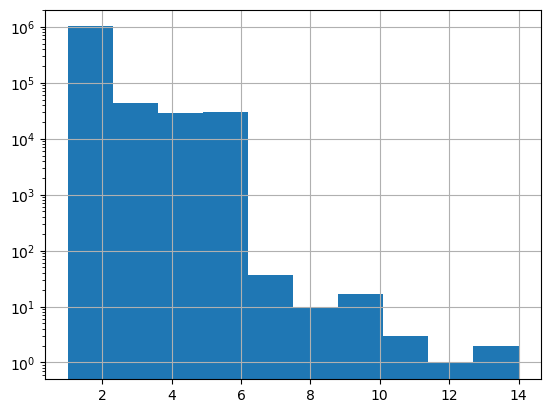

In [88]:
connected_components_df.external_id.value_counts().hist(log=True)



In [90]:
connected_components_df.to_csv('connected_components_df.csv', index=False)